In [2]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00


In [3]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import pickle
import streamlit as st

In [4]:
import pandas as pd
df = pd.read_csv(r'/content/creditcard.csv')

In [5]:
# Display basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5974 entries, 0 to 5973
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    5974 non-null   int64  
 1   V1      5974 non-null   float64
 2   V2      5974 non-null   float64
 3   V3      5974 non-null   float64
 4   V4      5974 non-null   float64
 5   V5      5974 non-null   float64
 6   V6      5974 non-null   float64
 7   V7      5974 non-null   float64
 8   V8      5974 non-null   float64
 9   V9      5974 non-null   float64
 10  V10     5974 non-null   float64
 11  V11     5974 non-null   float64
 12  V12     5974 non-null   float64
 13  V13     5974 non-null   float64
 14  V14     5974 non-null   float64
 15  V15     5974 non-null   float64
 16  V16     5974 non-null   float64
 17  V17     5974 non-null   float64
 18  V18     5973 non-null   float64
 19  V19     5973 non-null   float64
 20  V20     5973 non-null   float64
 21  V21     5973 non-null   float64
 22  

In [6]:
# Check for missing values
print(df.isnull().sum())

# Since all features except Time and Amount are PCA transformed, we'll scale these two
from sklearn.preprocessing import RobustScaler

# Scale 'Time' and 'Amount'
scaler = RobustScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Drop original Time and Amount columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Check class distribution
print(df['Class'].value_counts())
print("\nFraud percentage: {:.4f}%".format(len(df[df['Class']==1])/len(df)*100))

# Highly imbalanced dataset (0.1727% fraud)

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64
Class
0.0    5970
1.0       3
Name: count, dtype: int64

Fraud percentage: 0.0502%


In [8]:
# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Drop rows with NaN values in the target variable
y.dropna(inplace=True)
X = X.loc[y.index] # Update X accordingly to match dropped rows in y

# Split into train and test sets before resampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Get the number of samples in the majority class (class 0)
n_majority_samples = y_train.value_counts()[0]

# Create resampling pipeline
# Adjust sampling_strategy for RandomUnderSampler
resampling_pipeline = Pipeline([
    ('under', RandomUnderSampler(sampling_strategy='majority', random_state=42)), # Undersample the majority class
    ('over', SMOTE(sampling_strategy='minority', random_state=42)) # Oversample the minority class
])

# Apply resampling
X_resampled, y_resampled = resampling_pipeline.fit_resample(X_train, y_train)

# Check new distribution
print(pd.Series(y_resampled).value_counts())

Class
0.0    2
1.0    2
Name: count, dtype: int64


In [9]:
# Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest.fit(X_resampled)

# Predictions
iso_preds = iso_forest.predict(X_test)
iso_preds = [1 if x == -1 else 0 for x in iso_preds]  # Convert to 0/1 (1 is anomaly/fraud)

# Evaluation
print("Isolation Forest Results:")
print(classification_report(y_test, iso_preds))
print(confusion_matrix(y_test, iso_preds))

# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
lof_preds = lof.fit_predict(X_test)
lof_preds = [1 if x == -1 else 0 for x in lof_preds]  # Convert to 0/1

# Evaluation
print("\nLocal Outlier Factor Results:")
print(classification_report(y_test, lof_preds))
print(confusion_matrix(y_test, lof_preds))

Isolation Forest Results:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1194
         1.0       0.00      0.00      0.00         1

    accuracy                           1.00      1195
   macro avg       0.50      0.50      0.50      1195
weighted avg       1.00      1.00      1.00      1195

[[1194    0]
 [   1    0]]

Local Outlier Factor Results:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      1194
         1.0       0.01      1.00      0.02         1

    accuracy                           0.91      1195
   macro avg       0.50      0.96      0.49      1195
weighted avg       1.00      0.91      0.95      1195

[[1087  107]
 [   0    1]]



XGBoost Results:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1194
         1.0       0.00      0.00      0.00         1

    accuracy                           1.00      1195
   macro avg       0.50      0.50      0.50      1195
weighted avg       1.00      1.00      1.00      1195

[[1194    0]
 [   1    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


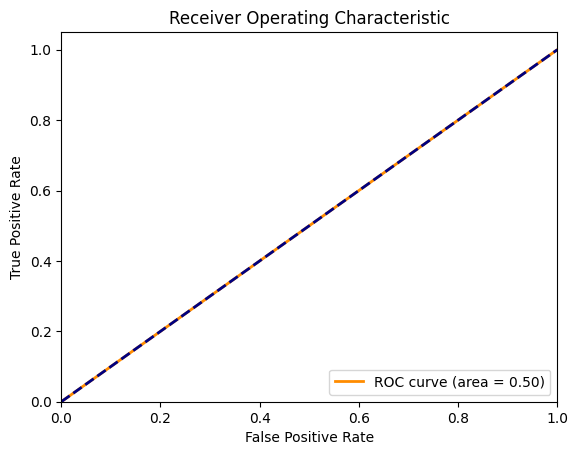

In [11]:
# Train XGBoost
import matplotlib.pyplot as plt # Import the pyplot module
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=-999,
    random_state=42,
    eval_metric='auc'
)

xgb.fit(X_resampled, y_resampled)

# Predictions
xgb_preds = xgb.predict(X_test)
xgb_probs = xgb.predict_proba(X_test)[:, 1]

# Evaluation
print("\nXGBoost Results:")
print(classification_report(y_test, xgb_preds))
print(confusion_matrix(y_test, xgb_preds))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, xgb_probs)
roc_auc = auc(fpr, tpr)

plt.figure() # Now plt is defined and can be used
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

In [12]:
# Save the trained model and scaler
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)